# Section 3.3S — Introduction to hypothesis testing

This notebook contains the code examples from [**Section 3.3 Introduction to hypothesis testing**]() of the **No Bullshit Guide to Statistics**.

I highly recommend that you use the notebook interactively.
I've intentionally left empty code cells throughout the notebook,
which you can use to try some commands on your own.
For example,
you can copy-paste some of the commands in previous cells,
modify them and run to see what happens.
Try to break things.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import nicebins
from plot_helpers import plot_pdf
from plot_helpers import savefigure


In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]
# red = sns.color_palette("tab10")[3]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/intro_to_NHST"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions

- estimator (statistic)



In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

### What is hypothesis testing?

- An approach to formulating research questions as **yes-no decisions** and a **procedure for making these decisions**.
- Hypothesis testing is a standardized procedure for doing statistical analysis  
  (also uses stats jargon that makes everything look more convincing ;)
- We formulate research question as two **competing hypotheses**:
  - **Null hypothesis $H_0$** = no effect.  
  - **Alternative hypothesis $H_A$** = an effect exists.
- NEW CONCEPT: the $p$-value is the probability of observing statistic (or more extreme) under the null hypothesis.


## The logic of hypothesis testing

### Overview of the hypothesis testing procedure

Here is the high-level overview of the hypothesis testing procedure:
 - **inputs**: sample statistics computed from the observed data
 - **outputs**: a decision that is one of: "reject the null hypothesis" or "fail to reject the null hypothesis"

![hypothesis testing overview](./attachments/stats/intro_to_hypothesis_testing.png)



In this notebook, we'll look at two different approaches for computing the sampling distributions:
simulations and analytical approximations.

### Interpreting the result of a hypothesis test (optional)



- The implication of rejecting the null hypothesis is that there must be a difference between the observed sample and the theoretical model.
  - Note that rejecting null hypothesis ($H_0$) is not the same as "proving" the alternative hypothesis ($H_A$);
    we have just shown that the data is unlikely under the null hypothesis.
    The conclusion is that it's worth looking for *some* alternative hypothesis.
  - Using statistics jargon, when we reject the hypothesis $H_0$ we say we've observed a "statistically significant" result,
    which sounds a lot more impressive than it actually is.
    The null hypothesis testing procedure is used to just rule out "occurred by chance" scenario,
    which is a very basic sanity check.    

- The implication of failing to reject the null hypothesis is that the observed sample is "not significant," meaning it could have occurred by chance,
  so there is no need to search for an alternative hypothesis.
  - Note that "failing to reject" is not the same as "proving" the null hypothesis.

I know all this sounds super complicated and roundabout (an it is!),
but you will get a hang of it with practice.

### Effect size estimates

The **effect size** $\Delta$ describes the *magnitude* of the deviation of the observed statistic
from the expected theoretical value.
For example,
in a test that compare the sample mean $\overline{\mathbf{x}}$ to a theoretical mean $\mu_{X_0}$,
the effect size estimate can be obtain from $\widehat{\Delta} = \overline{\mathbf{x}} - \mu_{X_0}$.

Another way to report effect size is to construct a **confidence interval**,
which takes into account the variability of the data.
The confidence interval that tells us a range of values where we believe the true value of $\Delta$ falls.
The functions `ci_mean` and `ci_var` from the `stats_helpers` module can help us with confidence interval calculations.

## Simulation tests

Let's start with a description of the problem.
We want to compare a sample of observations from an unknown population to a **fully specified theoretical model**.



In [6]:
def gen_sampling_dist(rv, estfunc, n, N=10000):
    """
    Simulate `N` samples of size `n` from the random variable `rv` to
    generate the sampling distribution of the estimator `estfunc`.
    """
    estimates = []
    for i in range(0, N):
        sample = rv.rvs(n)
        estimate = estfunc(sample)
        estimates.append(estimate)
    return estimates

## Test for the sample mean

#### Kombucha bottling process

We'll use the kombucha scenario for all the examples in this section.
Recall, the probability distirbution of the kombucha volume is described by
the theoretical model $K_0 \sim \mathcal{N}(\mu_{K_0} = 1000, \sigma_{K_0}=10)$
when the production line is working as expected.

We can use simulation to obtain the sampling distribution since $\mu_{K_0}$ and $\sigma_{K_0}$ are known.

#### Distribution under the null

In [7]:
from scipy.stats import norm

# theoretical model for the kombucha volumes
muK0 = 1000   # population mean (expected kombucha volume)
sigmaK0 = 10  # population standard deviation

rvK0 = norm(muK0, sigmaK0)

In [8]:
np.random.seed(42)
rvK0.rvs(size=20).round(2)

array([1004.97,  998.62, 1006.48, 1015.23,  997.66,  997.66, 1015.79,
       1007.67,  995.31, 1005.43,  995.37,  995.34, 1002.42,  980.87,
        982.75,  994.38,  989.87, 1003.14,  990.92,  985.88])

### Sampling distribution of the mean under the null

We can generate the sampling distribution of the mean $\overline{\mathbf{K}}_0$
by calling the helper function `gen_sampling_dist`.

In [9]:
from stats_helpers import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)

<Axes: ylabel='Count'>

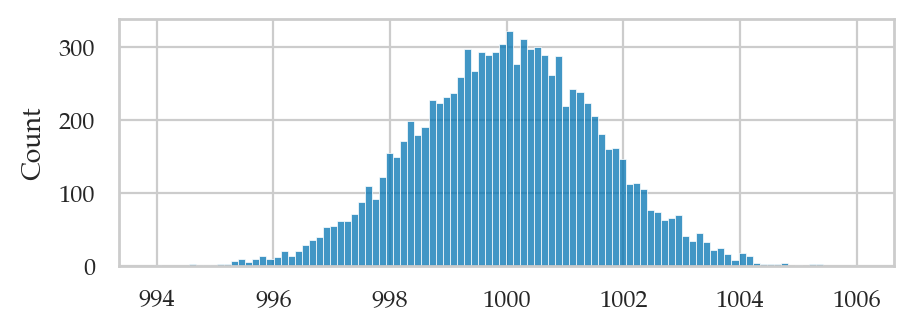

In [10]:
sns.histplot(kbars40, bins=100)

Saved figure to figures/stats/intro_to_NHST/hist_kbars40.pdf
Saved figure to figures/stats/intro_to_NHST/hist_kbars40.png


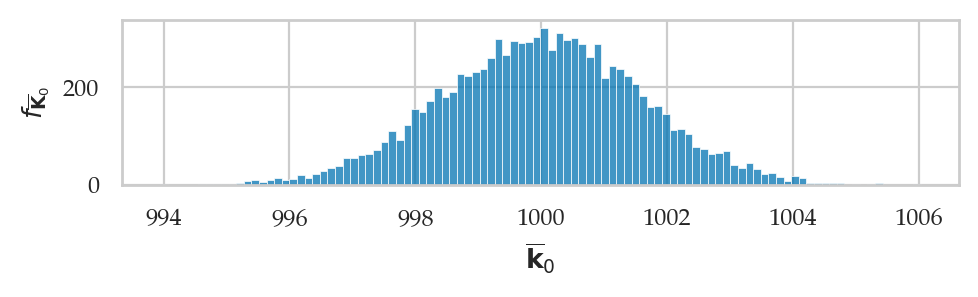

In [11]:
filename = os.path.join(DESTDIR, "hist_kbars40.pdf")
ax = sns.histplot(kbars40, bins=100)
ax.set_xlabel("$\overline{\mathbf{k}}_0$")
ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")
savefigure(ax, filename)

### Example 1S: test for the mean of Batch 04

$$
    H_0: \;\; \mu = \mu_{K_0} = 1000,
    \qquad \qquad
    H_A: \;\; \mu \neq \mu_{K_0}.
$$

In words,
the null hypothesis describes a regular batch,
where the mean of the batch is equal to the mean of the model $\mu_{K_0}=1000$.

Let's start by loading the sample $\mathbf{k}_{04}$ from Batch 04 of the `kombucha` dataset.

In [12]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch04 = kombucha[kombucha["batch"]==4]
ksample04 = batch04["volume"]

In [13]:
len(ksample04)

40

In [14]:
# observed mean
obsmean04 = mean(ksample04)
obsmean04

1003.8335

The mean volume calculated from the sample `ksample04` is $3.83$ ml higher than the expected mean $\mu_{K_0} = 1000$ ml.
Is this a big difference or not?
How likely is such deviation to occur by chance under the null hypothesis?

#### Sampling distribution under the null hypothesis

To answer the above question,
we need to generate the sampling distribution of the mean
for samples of size $n=40$ under the null hypothesis $H_0$.
We can do this using the `gen_sampling_dist` function,
by providing it the probability model `rvK0` $= K_0 \sim \mathcal{N}(\mu_{K_0}=1000,\sigma_{K_0}=10)$,
which describes the variability of the kombucha volumes when the factory is operating correctly.

We can now generate the sampling distribution of the mean using simulation.

In [15]:
from stats_helpers import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)

To calculate the $p$-value,
we want to count how many values of sampling distribution `kbars40`
are equal or more extreme than the observed value $\overline{\mathbf{k}}_{04} =$ `obsmean04` = 1003.8335.

In [16]:
dev = abs(obsmean04 - muK0)
dev

3.833499999999958

In [17]:
tails = [v for v in kbars40 if abs(v-muK0) >= dev]
tails[0:3]

[1004.786610717458, 995.7701787502498, 995.8232443556451]

In [18]:
len(tails)

149

In [19]:
pvalue04 = len(tails) / len(kbars40)
pvalue04

0.0149

The $p$-value is the ratio of the number of observations in the tails,
divided by the total number of simulated observations.

We can visualize the above calculation by plotting a histogram of sampling distribution $\overline{\mathbf{K}}_0$
and highlighting the parts in the tails.

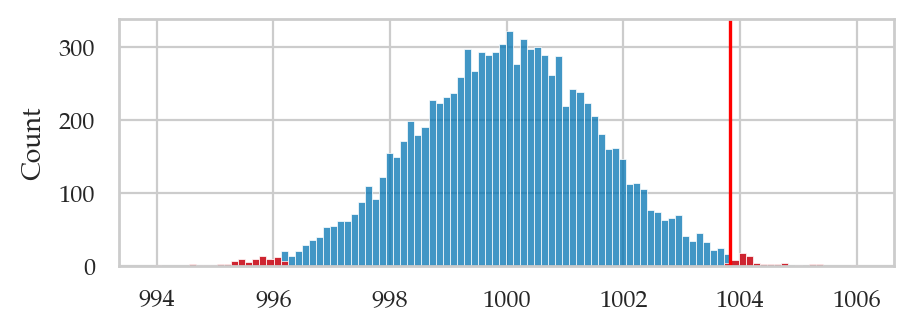

In [20]:
# plot the sampling distribution as a histogram
sns.histplot(kbars40, bins=100)

# plot red line for the observed mean
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
_ = sns.histplot(tails, bins=100, color="red")

In [21]:
1000 - (obsmean04 - 1000)

996.1665

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean04.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean04.png


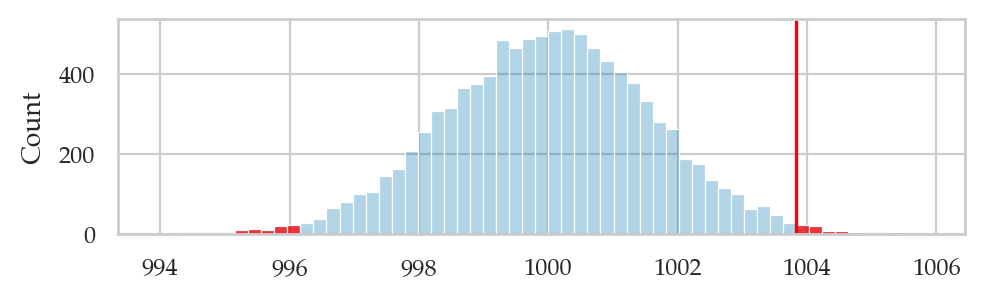

In [22]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsmean04.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kbars40, obsmean04)
ax = sns.histplot(kbars40, bins=bins, alpha=0.3)

# plot red line for the observed statistic
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
# ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")

savefigure(ax, filename)

We can now make the decision based on the $p$-value and a pre-determined threshold,
which is conventionally chosen $\alpha=0.05$ (1 in 20).
The $p$-value is 0.015,
which means $\overline{\mathbf{k}}_{04} = 1003.83$ has only a 1.5\% chance of occurring under the null hypothesis.
Since the observed value of the mean `obsmean04` = 1003.8335 is unlikely under $H_0$,
our decision is to "reject the null hypothesis."

Recall the math statement of the null hypothesis is $H_0: \mu = \mu_{K_0} = 1000$,
which describes a batch whose mean is equal to the mean of the model $\mu_{K_0}$.
The conclusion to reject $H_0$ tells us the batch is irregular.

#### Effect size estimates

We were able to detect that batch differs from the expected distribution,
but how big is the deviation?
We can use the deviation from the expected mean as measure of the effect size $\widehat{\Delta} = \overline{\mathbf{k}} - \mu_{K_0}$ in this situation.

In [23]:
mean(ksample04) - muK0

3.833499999999958

The point estimate $\widehat{\Delta} = \overline{\mathbf{k}}_{04} - \mu_{K_0} = 3.83$
tells us how much the mean of the sample differs from the expected population mean $\mu_{K_0}$,
but doesn't tell us the uncertainty in this estimate.

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.
The function `ci_mean` that we defined earlier performs the exact same operation,
when called with the argument `method="b"`.

In [24]:
from stats_helpers import ci_mean

np.random.seed(48)
ci_mean(ksample04-muK0, alpha=0.1, method="b")

[1.7537499999999935, 5.802025000000007]

The confidence interval $\ci{\Delta,0.9}^* = [1.75, 5.80]$ tells us the true discrepancy
of Batch 04 from the expected mean can be anywhere from 1.75 to 5.8.

### Example 2S: test for the mean of Batch 01

Let's repeat the procedure on the sample $\mathbf{k}_{01}$ which comes from Batch 01.

In [25]:
batch01 = kombucha[kombucha["batch"]==1]
ksample01 = batch01["volume"]
len(ksample01)

40

In [26]:
obsmean01 = mean(ksample01)
obsmean01

999.10375

In [27]:
np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)

In [28]:
dev = abs(obsmean01 - muK0)
tails = [v for v in kbars40 if abs(v-muK0) >= dev]
pvalue01 = len(tails) / len(kbars40)
pvalue01

0.5711

The large $p$-value tells us that the observed mean $\overline{\mathbf{k}}_{01} = 999.10$ is not unlikely under $H_0$.
Using the terminology of hypothesis testing,
we say the outcome of the hypothesis test is that we *failed to reject* $H_0: \mu = \mu_{K_0}$.
We have not seen any evidence that suggests that the mean of the population from
which sample `ksample01` was taken differs from the mean of the theoretical model $K_0$.

Ship it!

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean01.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean01.png


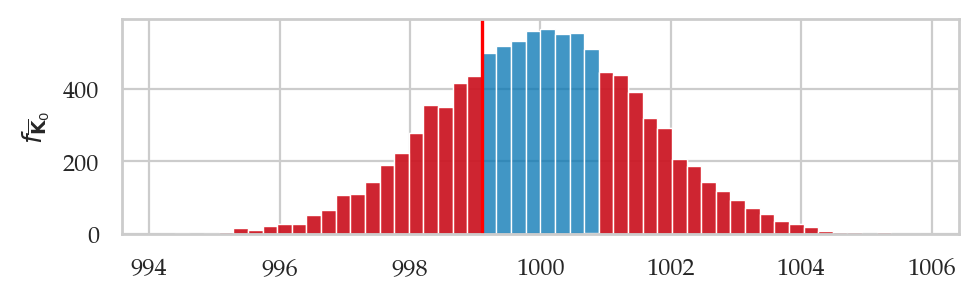

In [29]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsmean01.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kbars40, obsmean01)
ax = sns.histplot(kbars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsmean01, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")

savefigure(ax, filename)

### Reusable test function

Let's write a reusable function for performing the simulation test for the mean.

In [30]:
#######################################################

def simulation_test_mean(sample, mu0, sigma0, N=10000):
    """
    Compute the p-value of the observed mean of `sample`
    under H0 of a normal distribution `norm(mu0,sigma0)`.
    """
    # Compute the observed value of the mean
    obsmean = mean(sample)

    # Obtain the sampling dist. of the mean under H0
    n = len(sample)
    rvXH0 = norm(mu0, sigma0)
    xbars = gen_sampling_dist(rvXH0, estfunc=mean, n=n)

    # Compute the p-value
    # tails = tailvalues(xbars, obsmean)
    dev = abs(obsmean - mu0)
    tails = [v for v in xbars if abs(v-muK0) >= dev]
    pvalue = len(tails) / len(xbars)
    return pvalue


In [31]:
## TEST 1 (Do we get the same answer for Batch 04?)
np.random.seed(42)
simulation_test_mean(ksample04, mu0=muK0, sigma0=sigmaK0)

0.0149

In [32]:
## TEST 2 (Do we get the same answer for Batch 01?)
np.random.seed(42)
simulation_test_mean(ksample01, mu0=muK0, sigma0=sigmaK0)

0.5711

We have confirmed the function `simulation_test_mean` works as expected.
We've added it to `stats_helpers` module so we can reuse it later.

## Test for the sample variance

#### Sampling distribution of the variance under the null

We can generate the the sampling distribution of the variance $S^2_{\mathbf{K}_0}$
by calling the helper function `gen_sampling_dist`.

In [33]:
from stats_helpers import gen_sampling_dist

np.random.seed(42)
kvars20 = gen_sampling_dist(rvK0, estfunc=var, n=20)

<Axes: ylabel='Count'>

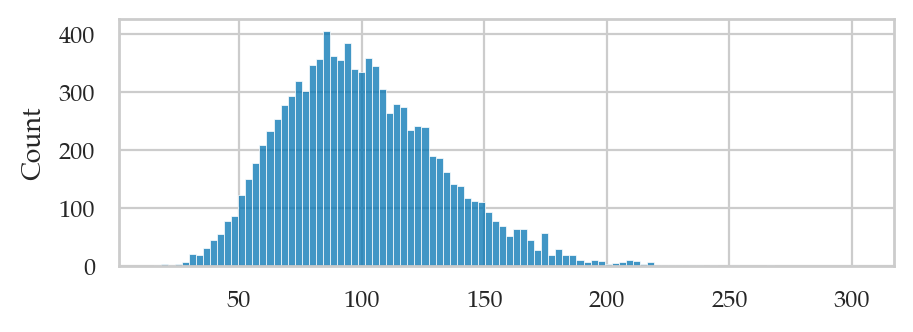

In [34]:
sns.histplot(kvars20, bins=100)

Saved figure to figures/stats/intro_to_NHST/hist_kvars20.pdf
Saved figure to figures/stats/intro_to_NHST/hist_kvars20.png


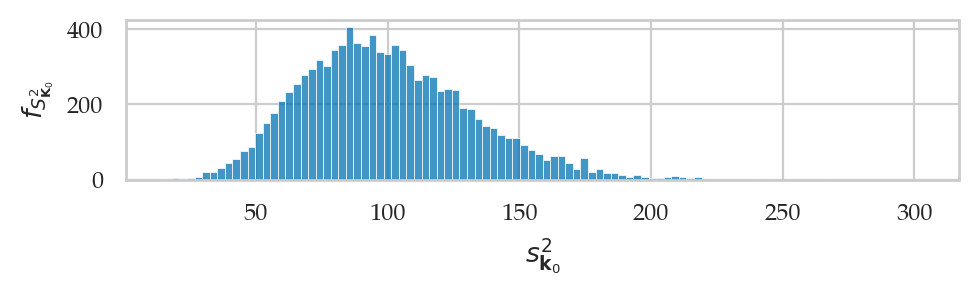

In [35]:
filename = os.path.join(DESTDIR, "hist_kvars20.pdf")
ax = sns.histplot(kvars20, bins=100)
ax.set_xlabel("$s_{{\mathbf{k}}_0}^2}$")
ax.set_ylabel("$f_{S_{{\mathbf{K}}_0}^2}$")
savefigure(ax, filename)

### Example 3S: test for the variance of Batch 02

Let's assume the sample of volume measurements $\mathbf{k}_{02}$ from the Batch 02 of the kombucha bottling plant comes from a population with unknown variance $\sigma^2$,
which we can estimate by computing the sample variance $s^2_{\mathbf{k}_{02}}$.

We want to check whether Batch 02 is a "regular" or "irregular" by comparing the variance in the volumes
of this batch $\sigma^2$ to the variance of the theoretical model $\sigma_{K_0}^2= 100$.
Specifically,
we're interested in detecting the case when the variance is higher than expected:

$$
    H_0: \;\; \sigma^2 \leq \sigma_{K_0}^2,
    \qquad \qquad
    H_A: \;\; \sigma^2 > \sigma_{K_0}^2.
$$

Note the alternative hypothesis uses the "greater than" inequality,
since we don't mind batches with low variance.

In [36]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
len(ksample02)

20

In [37]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [38]:
np.random.seed(42)
kvars20 = gen_sampling_dist(rvK0, estfunc=var, n=20)

In [39]:
right_tail = [v for v in kvars20 if v >= obsvar02]
pvalue02 = len(right_tail) / len(kvars20)
pvalue02

0.2132

The $p$-value is greater than the cutoff value $\alpha = 0.05$,
so our decision is "fail to reject $H_0$."

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar02.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar02.png


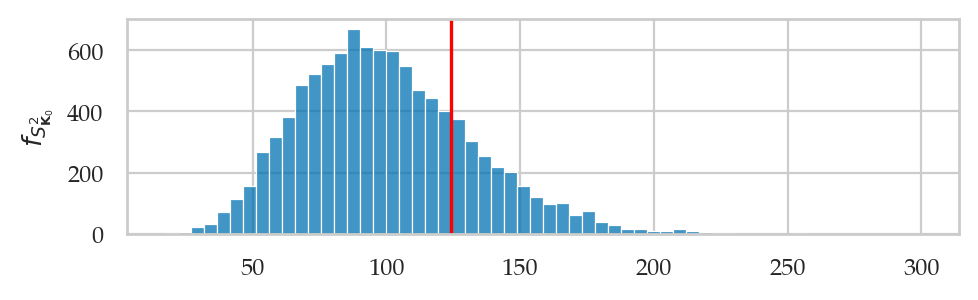

In [40]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsvar02.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kvars20, obsvar02)
ax = sns.histplot(kvars20, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar02, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{S^2_{\mathbf{K}_0}}$")

savefigure(ax, filename)

### Example 4S: test for the variance of Batch 08

In [41]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch08 = kombucha[kombucha["batch"]==8]
ksample08 = batch08["volume"]
len(ksample08)

40

In [42]:
obsvar08 = var(ksample08)
obsvar08

169.9979220512824

We'll now generate the sampling distribution of the variance for sample of size $n=40$.

In [43]:
np.random.seed(43)
kvars40 = gen_sampling_dist(rvK0, estfunc=var, n=40)

In [44]:
right_tail = [v for v in kvars40 if v >= obsvar08]
pvalue08 = len(right_tail) / len(kvars40)
pvalue08

0.0041

The $p$-value is very small,
so our decision is to reject $H_0$.

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar08.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar08.png


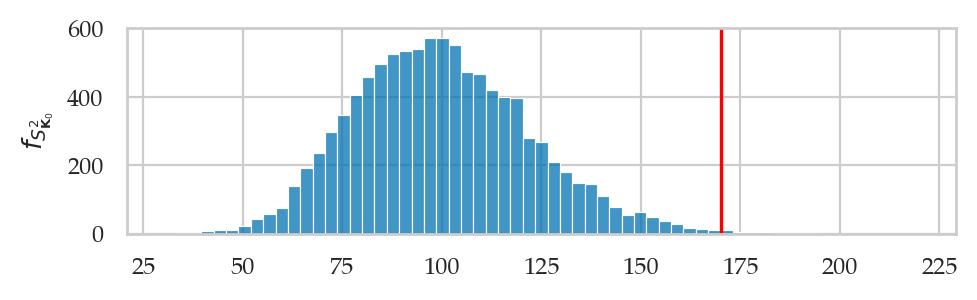

In [45]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsvar08.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kvars40, obsvar08)
ax = sns.histplot(kvars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar08, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{S^2_{\mathbf{K}_0}}$")

savefigure(ax, filename)

#### Effect size estimates

We found the variance in the volumes in this batch is higher than the expected variance.
Now let's estimate the effect size $\widehat{\Delta} = s^2_{\mathbf{k}_{08}} / \sigma_{K_0}^2$.

In [46]:
var(ksample08) / sigmaK0**2

1.699979220512824

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.
We can obtain $\ci{\Delta,0.9}^*$ by first computing a 90\% bootstrap confidence interval
for the variance $\ci{\sigma^2,0.9}^*$,
then dividing by the theoretical variance $\sigma_{K_0}^2$.

In [47]:
from stats_helpers import ci_var

np.random.seed(48)
civar08_boot = ci_var(ksample08, alpha=0.1, method="b")
civar08_boot

[117.37369362820536, 217.98659930448775]

In [48]:
ci_l = civar08_boot[0] / sigmaK0**2
ci_u = civar08_boot[1] / sigmaK0**2
[ci_l, ci_u]

[1.1737369362820536, 2.1798659930448774]

The interval $\ci{\Delta,0.9}^* = [1.17, 2.18]$ tells us the observed sample variance
in Batch 08 is somewhere between 1.17 and 2.18 times the expected variance $\sigma_{K_0}^2$ under the null hypothesis.

### Generic simulation test function

In [49]:
#######################################################

def simulation_test_var(sample, mu0, sigma0, alt="greater"):
    """
    Compute the p-value of the observed variance of `sample`
    under H0 of a normal distribution `norm(mu0,sigma0)`.
    """
    # 1. Compute the sample variance
    obsvar = var(sample)
    n = len(sample)

    # 2. Get sampling distribution of variance under H0
    rvXH0 = norm(mu0, sigma0)
    xvars = gen_sampling_dist(rvXH0, estfunc=var, n=n)

    # 3. Compute the p-value
    tails = [xvar for xvar in xvars if xvar >= obsvar]
    pvalue = len(tails) / len(xvars)
    return pvalue

In [50]:
# reproduce the results from Example 3
np.random.seed(42)
simulation_test_var(ksample02, muK0, sigmaK0, alt="greater")

0.2132

In [51]:
# reproduce the results from Example 4
np.random.seed(43)
simulation_test_var(ksample08, muK0, sigmaK0, alt="greater")

0.0041

We confirm the function `simulation_test_var` gives the same $p$-values as the two samples
we calculated manually above,
so we can be confident it is working as expected.

## Explanations

### Summary of the hypothesis testing procedure

### Statistical modelling and assumptions

### Two different probability models

### One-sided and two-sided tests

Saved figure to figures/stats/intro_to_NHST/panel_hist_p-values_left_twotailed_right_tests.pdf
Saved figure to figures/stats/intro_to_NHST/panel_hist_p-values_left_twotailed_right_tests.png


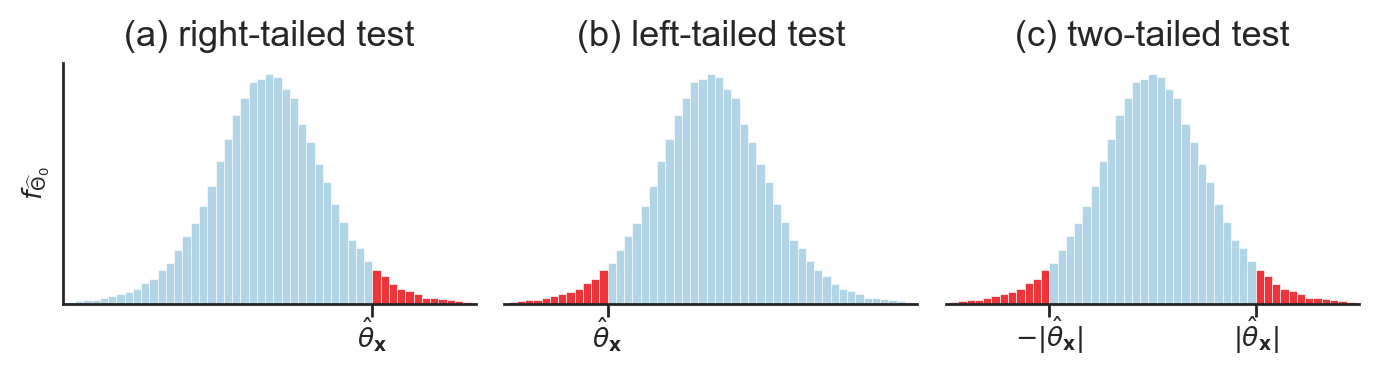

In [52]:
filename = os.path.join(DESTDIR, "panel_hist_p-values_left_twotailed_right_tests.pdf")
from stats_helpers import tailvalues
from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = nicebins(xs, 2, nbins=50)

with plt.rc_context({"figure.figsize":(7,2)}), sns.axes_style("ticks"):
    fig, (ax3, ax1, ax2) = plt.subplots(1, 3, sharey=True)
    ax3.set_ylabel("$f_{\widehat{\Theta}_0}$")

    # RIGHT
    title = '(a) right-tailed test'
    ax3.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax3, bins=bins, alpha=0.3)
    ax3.set_xlim(-4, 4)
    ax3.set_xticks([2])
    ax3.set_xticklabels([])
    ax3.set_yticks([])
    ax3.spines[['right', 'top']].set_visible(False)
    # highlight the right tail
    tailvalues3 = [t for t in ts if t >= 2]
    sns.histplot(tailvalues3, bins=bins, ax=ax3, color="red")
    ax3.text(2, -300, "$\hat{\\theta}_{\mathbf{x}}$", verticalalignment="top", horizontalalignment="center")

    # LEFT
    title = '(b) left-tailed test'
    ax1.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax1, bins=bins, alpha=0.3)
    ax1.set_xlim(-4, 4)
    ax1.set_xticks([-2])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_ylabel("")
    ax1.spines[['left', 'right', 'top']].set_visible(False)
    # highlight the left tail
    tailvalues1 = tailvalues(ts, -2, alt="less")
    sns.histplot(tailvalues1, bins=bins, ax=ax1, color="red")
    ax1.text(-2, -300, r"$\hat{\theta}_{\mathbf{x}}$", va="top", ha="center")

    # TWO-TAILED
    title = '(c) two-tailed test'
    ax2.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax2, bins=bins, alpha=0.3)
    ax2.set_xlim(-4, 4)
    ax2.set_xticks([-2,2])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.spines[['left', 'right', 'top']].set_visible(False)
    # highlight the left and right tails
    tailvalues2 = [t for t in ts if t <= -2 or t >= 2]
    sns.histplot(tailvalues2, bins=bins, ax=ax2, color="red")
    ax2.text(-2, -300, r"$-|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")
    ax2.text(2, -300, r"$|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")

savefigure(fig, filename)

#### Selecting the tails of a distribution

The concept of statistics that are "equal or more extreme than" the observed statistic $\hat{\theta}_{\mathbf{x}}$
is essential to the logic of hypothesis testing.

In [53]:
def tailvalues(valuesH0, obs, alt="two-sided"):
    """
    Select the subset of the elements in list `valuesH0` that
    are equal or more extreme than the observed value `obs`.
    """
    assert alt in ["greater", "less", "two-sided"]
    valuesH0 = np.array(valuesH0)
    if alt == "greater":
        tails = valuesH0[valuesH0 >= obs]
    elif alt == "less":
        tails = valuesH0[valuesH0 <= obs]
    elif alt == "two-sided":
        meanH0 = np.mean(valuesH0)
        dev = abs(obs - meanH0)
        tails = valuesH0[abs(valuesH0-meanH0) >= dev]
    return tails

For right-tailed tests,
we call `tailvalues` with the option `alt="greater"`,
which will select the subset of values in the list
`valuesH0` that are equal to or greater than the observed statistic `obs`.

UPDATE ME TODO
For two-tailed tests, like the Example 1S,
we want to select the observations that are equal to or more extreme than the deviation
of the observed statistic `obs`.
This means all values that are greater than `|obs|` and less than `-|obs|`.

#### One-sided $p$-value calculation example

We can verify that  the function `tailvalues` works as expected
by reproducing the $p$-value calculation from Example 3S.
Reusing the variables $\tt{obsvar02} = s_{\mathbf{k}_{02}}^2 = 124.32$ we calculated above,
we can obtain the $p$-value by calling the helper function `tailvalues` with the option `alt="greater"`
then divide by the total number of simulations:

In [54]:
np.random.seed(42)
kvars20 = gen_sampling_dist(rvK0, estfunc=var, n=20)
tails = tailvalues(kvars20, obsvar02, alt="greater")
len(tails) / len(kvars20)

0.2132

The value we obtain is identical to the $p$-value $\tt{pvalue02} = 0.2132$ that we computed in Example 3S,
so we know the function `tailvalues` works as expected for $p$-value calculations of type \textbf{(a)},
where we want to detect positive deviations from the expected distribution under $H_0$.

#### Two-sided $p$-value calculation example

Reusing the $\tt{obsmean04} = \overline{\mathbf{x}}_{04} = 1003.8335$
that we calculated earlier in Example~1S,
we can obtain the $p$-value by calling the function `tailvalues`
with the option `alt="two-sided"` then divide by the total number of simulations:

In [55]:
np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)
tails = tailvalues(kbars40, obsmean04, alt="two-sided")
len(tails) / len(kbars40)

0.015

The value we obtain is identical to the $p$-value that we obtained in Example~1S,
so we know the function `tailvalues` works as expected for $p$-value calculations of type \textbf{(c)},
where we want to detect both positive and negative deviations from the expected distribution under $H_0$.

### Court trial analogy

## Discussion

### Hypothesis testing decision rule

In [56]:
#######################################################
def getdecision(pvalue, alpha=0.05):
    """
    Check if `pvalue` is less than or equal to `alpha`.
    """
    if pvalue < alpha:
        # The observed statistics is unlikely to have
        # occurred under the null hypothesis
        print("reject H0")
    else:
        # The observed statistics could have occurred
        # under the null hypothesis
        print("retain H0")

^ The above can be used as a lead-in to introduce the p-value problems...

### Standardized effect size

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.
Cohen's $d$ is one such measure, and it is defined as the difference between the observed mean and an expected mean divided by the sample standard deviation.

In [57]:
def cohend(sample, mu0):
    """
    Cohen's d for one group compared to the theoretical mean `mu0`.
    """
    obsmean = mean(sample)
    obsstd = std(sample)
    cohend = (obsmean - mu0) / obsstd
    return cohend

We can interpret the value of Cohen's $d$ obtained using this [table of reference values](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d):

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |


Effect size for mean deviation of kombucha Batch 04 from expected value $\mu_{K_0}=1000$.

In [58]:
cohend(ksample04, mu0=1000)

0.4882087345321637

## Exercises

In [59]:
# TODO

## Links

* [The Introductory Statistics Course: A Ptolemaic Curriculum](https://minireference.com/blog/wp-content/uploads/2021/03/TheIntroductoryStatisticsCourse__Cobb.pdf) by George W. Cobb
* [What Teachers Should Know About the Bootstrap: Resampling in the Undergraduate Statistics Curriculum](https://www.tandfonline.com/doi/full/10.1080/00031305.2015.1089789) by Tim C. Hesterberg  
* \[BOOK\] [Think Stats 2e](https://greenteapress.com/wp/think-stats-2e/) by Allen B. Downey  
* \[VIDEO\] [There's Only One Test](https://www.youtube.com/watch?v=S41zQEshs5k) by Allen B. Downey
* \[TALK\] [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) by Jake Vanderplas